**1. Importing all libraries**

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sqlite3 

**2. Connecting dataset**

In [88]:
def create_connection(db_file):
    global conn
    if 'conn' in globals() and conn:
        conn.close()
    conn = sqlite3.connect(db_file)
    return conn

conn = create_connection('mental_health.sqlite')

**3. Checking database**

In [89]:
query = """
SELECT name 
FROM sqlite_master 
WHERE type='table';
"""
tables = conn.execute(query).fetchall()
tables = [row[0] for row in tables] 

print("Tables in the database:")
for table in tables:
    print(f" - {table}")


Tables in the database:
 - Answer
 - Question
 - Survey


By checking table names from base table schema information I can tell there are 3 tables

In [90]:
table_query = """
SELECT name 
FROM sqlite_master 
WHERE type='table';
"""
tables = conn.execute(table_query).fetchall()

for table in tables:
    table_name = table[0]  

    row_count_query = f"""
    SELECT COUNT(*) 
    FROM {table_name};
    """
    row_count = conn.execute(row_count_query).fetchone()[0]

    column_query = f"""
    PRAGMA table_info({table_name});
    """
    columns = conn.execute(column_query).fetchall()
    column_names = [col[1] for col in columns]

    print(f"\nTable: {table_name}")
    print(f" - Rows: {row_count}")
    print(f" - Columns: {', '.join(column_names)}")



Table: Answer
 - Rows: 236898
 - Columns: AnswerText, SurveyID, UserID, QuestionID

Table: Question
 - Rows: 105
 - Columns: questiontext, questionid

Table: Survey
 - Rows: 5
 - Columns: SurveyID, Description


Checking each tables row count and columns with their name tags. From this I can tell that Answers is the main table which connects both Survey and Question tables.
There are 5 surveys, 105 questions and 236898 entries consisting answers. 

**4. Checking NULL values**

In [91]:
query = """
SELECT m.name AS table_name, p.name AS column_name 
FROM sqlite_master m
JOIN pragma_table_info(m.name) p
WHERE m.type='table';
"""
table_columns = conn.execute(query).fetchall() 

results = []
for table, column in table_columns:
    null_count = conn.execute(f"SELECT COUNT(*) FROM {table} WHERE {column} IS NULL;").fetchone()[0]
    if null_count > 0:
        results.append((table, column, null_count))

if results:
    print("\nNULL Values Found:")
    for table, column, count in results:
        print(f"Table: {table} | Column: {column} | NULLs: {count}")
else:
    print("No NULL values found in the database.")

No NULL values found in the database.


**5. Checking for duplicates**

In [92]:
query = """
SELECT QuestionID, UserID, COUNT(*) as duplicate_count
FROM Answer
GROUP BY QuestionID, UserID
HAVING COUNT(*) > 1;
"""

duplicates = conn.execute(query).fetchall()


if duplicates:
    print("\nDuplicate QuestionID per UserID found:")
    for row in duplicates:
        print(f"QuestionID: {row[0]} | UserID: {row[1]} | Duplicates: {row[2]}")
else:
    print("No duplicate QuestionID per UserID found.")


Duplicate QuestionID per UserID found:
QuestionID: 115 | UserID: 1262 | Duplicates: 2
QuestionID: 115 | UserID: 1264 | Duplicates: 2
QuestionID: 115 | UserID: 1265 | Duplicates: 2
QuestionID: 115 | UserID: 1266 | Duplicates: 3
QuestionID: 115 | UserID: 1268 | Duplicates: 2
QuestionID: 115 | UserID: 1270 | Duplicates: 2
QuestionID: 115 | UserID: 1275 | Duplicates: 2
QuestionID: 115 | UserID: 1277 | Duplicates: 4
QuestionID: 115 | UserID: 1279 | Duplicates: 2
QuestionID: 115 | UserID: 1280 | Duplicates: 2
QuestionID: 115 | UserID: 1290 | Duplicates: 2
QuestionID: 115 | UserID: 1292 | Duplicates: 4
QuestionID: 115 | UserID: 1295 | Duplicates: 2
QuestionID: 115 | UserID: 1301 | Duplicates: 2
QuestionID: 115 | UserID: 1304 | Duplicates: 2
QuestionID: 115 | UserID: 1306 | Duplicates: 3
QuestionID: 115 | UserID: 1307 | Duplicates: 4
QuestionID: 115 | UserID: 1310 | Duplicates: 2
QuestionID: 115 | UserID: 1314 | Duplicates: 2
QuestionID: 115 | UserID: 1327 | Duplicates: 2
QuestionID: 115 | Us

There are many duplicates anwers from many user to specific questions. To gain a better perspective, I will review the questions and answers to determine whether these duplicates are truly redundant or if they represent different answers to the same question.

In [93]:
query = """
SELECT * FROM Question
WHERE QuestionID IN (115, 116, 117);
"""
questions = conn.execute(query).fetchall()

print("\nQuestions with IDs 115, 116, and 117:")
for row in questions:
    print(row)


Questions with IDs 115, 116, and 117:
('If yes, what condition(s) have you been diagnosed with?', 115)
('If maybe, what condition(s) do you believe you have?', 116)
('Which of the following best describes your work position?', 117)


In [94]:
query = """
SELECT * FROM Answer
WHERE (QuestionID = 115 AND UserID = 1292)
   OR (QuestionID = 116 AND UserID = 2065)
   OR (QuestionID = 117 AND UserID = 1499);
"""

results = conn.execute(query).fetchall()

print("\nRecords for specified QuestionID & UserID pairs:")
for row in results:
    print(row) 


Records for specified QuestionID & UserID pairs:
('Anxiety Disorder (Generalized, Social, Phobia, etc)', 2016, 1292, 115)
('Mood Disorder (Depression, Bipolar Disorder, etc)', 2016, 1292, 115)
('Substance Use Disorder', 2016, 1292, 115)
('Addictive Disorder', 2016, 1292, 115)
('Anxiety Disorder (Generalized, Social, Phobia, etc)', 2016, 2065, 116)
('Mood Disorder (Depression, Bipolar Disorder, etc)', 2016, 2065, 116)
('Post-traumatic Stress Disorder', 2016, 2065, 116)
('Stress Response Syndromes', 2016, 2065, 116)
('Front-end Developer', 2016, 1499, 117)
('Back-end Developer', 2016, 1499, 117)
('Sales', 2016, 1499, 117)
('DevOps/SysAdmin', 2016, 1499, 117)


From this, I can tell that many users have provided more than one answer, indicating that these duplicates are not true duplicates but rather additional responses from users for a specific question. It would be incorrect to remove them.

**6. Question order** 

In [95]:
query = """
SELECT QuestionID
FROM Question 
ORDER BY QuestionID;
"""
question_ids = [row[0] for row in conn.execute(query).fetchall()]

missing_ids = [q for q in range(question_ids[0], question_ids[-1] + 1) if q not in question_ids]

if missing_ids:
    print("\nMissing QuestionIDs detected:")
    print(missing_ids)
else:
    print("All QuestionIDs are in proper sequence.")


Missing QuestionIDs detected:
[35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]


By observing the database I noticed that question_id's dont go in order. To not face problems in upcoming work, I check it and change the order. 

In [105]:
query_question_ids = """
SELECT QuestionID FROM Question ORDER BY QuestionID;
"""
question_ids = [row[0] for row in conn.execute(query_question_ids).fetchall()]
new_ids = list(range(1, len(question_ids) + 1))
id_mapping_questions = dict(zip(question_ids, new_ids))

for old_id, new_id in id_mapping_questions.items():
    update_question_query = f"""
    UPDATE Question 
    SET QuestionID = {new_id} 
    WHERE QuestionID = {old_id};
    """
    conn.execute(update_question_query)

conn.commit()


query_answer_ids = """
SELECT DISTINCT QuestionID FROM Answer ORDER BY QuestionID;
"""
answer_ids = [row[0] for row in conn.execute(query_answer_ids).fetchall()]
new_ids_answers = list(range(1, len(answer_ids) + 1))
id_mapping_answers = dict(zip(answer_ids, new_ids_answers))

for old_id, new_id in id_mapping_answers.items():
    update_answer_query = f"""
    UPDATE Answer 
    SET QuestionID = {new_id} 
    WHERE QuestionID = {old_id};
    """
    conn.execute(update_answer_query)

conn.commit()


By observing data, I see that evrything goes in order, so when connecting question IDs everything should be correct. 

In [97]:
query = """
SELECT QuestionID
FROM Question 
ORDER BY QuestionID;
"""
question_ids = [row[0] for row in conn.execute(query).fetchall()]

missing_ids = [q for q in range(question_ids[0], question_ids[-1] + 1) if q not in question_ids]


if missing_ids:
    print("\nMissing QuestionIDs detected:")
    print(missing_ids)
else:
    print("All QuestionIDs are in proper sequence.")

All QuestionIDs are in proper sequence.


**7. Standardizing the database**

In [108]:
query_tables = """
SELECT name 
FROM sqlite_master 
WHERE type='table';
"""

tables = [row[0] for row in conn.execute(query_tables).fetchall()]

for table in tables:
    column_query = f"PRAGMA table_info({table})"
    columns = conn.execute(column_query).fetchall()

    for col in columns:
        col_name = col[1] 
        col_type = col[2]  

        if "CHAR" in col_type.upper() or "TEXT" in col_type.upper():
            update_query = f"""
            UPDATE {table}
            SET {col_name} = TRIM(LOWER({col_name}))
            WHERE {col_name} IS NOT NULL;
            """
            conn.execute(update_query)
        
        if "DATE" in col_type.upper() or "date" in col_name.lower():
            update_query = f"""
            UPDATE {table}
            SET {col_name} = strftime('%Y-%m-%d', {col_name})
            WHERE {col_name} IS NOT NULL AND {col_name} != '';
            """
            conn.execute(update_query)

        if "INT" in col_type.upper() or "REAL" in col_type.upper():
            update_query = f"""
            UPDATE {table}
            SET {col_name} = CAST({col_name} AS INTEGER)
            WHERE {col_name} GLOB '[0-9]*';
            """
            conn.execute(update_query)
            
conn.commit()


 1.Trim whitespace and convert text to lowercase

 2.Fix date formatting to YYYY-MM-DD
 
 3.Ensure numerical columns have correct values


## **EDA**

Now I will examine the data to gain a comprehensive understanding of the respondents.

**1. Checking how many people reponed to each survey**

In [42]:
query = """
SELECT SurveyID, COUNT(DISTINCT UserID) AS respondent_count
FROM Answer
GROUP BY SurveyID
ORDER BY respondent_count DESC;
"""

survey_responses = conn.execute(query).fetchall()

print("\nSurvey Respondent Count:")
print("SurveyID | Respondent Count")
for survey_id, respondent_count in survey_responses:
    print(f"{survey_id:<8} | {respondent_count}")


Survey Respondent Count:
SurveyID | Respondent Count
2016     | 1433
2014     | 1260
2017     | 756
2018     | 417
2019     | 352


Here I can see that most of the answers comes from 2016 and 2014. There is no survey from 2015. 

In [18]:
query = """
WITH valid_ages AS (
    SELECT CAST(AnswerText AS INTEGER) AS age
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
)
SELECT 
    (SELECT MIN(age) FROM valid_ages) AS youngest,
    (SELECT MAX(age) FROM valid_ages) AS oldest,
    (SELECT AVG(age) FROM valid_ages) AS mean_age,
    (SELECT age FROM valid_ages ORDER BY age LIMIT 1 OFFSET (SELECT COUNT(*)/2 FROM valid_ages)) AS median_age,
    (SELECT MAX(age) - MIN(age) FROM valid_ages) AS age_range,
    (SELECT age FROM valid_ages GROUP BY age ORDER BY COUNT(*) DESC LIMIT 1) AS mode_age
FROM valid_ages;
"""

age_stats = conn.execute(query).fetchone()
youngest, oldest, mean_age, median_age, age_range, mode_age = age_stats

print("\nSQL-Based Age Statistics for All Surveys:")
print("-------------------------------------------------------------------")
print(f"Youngest Respondent: {youngest}")
print(f"Oldest Respondent: {oldest}")
print(f"Mean Age: {mean_age:.2f}")
print(f"Median Age: {median_age}")
print(f"Age Range: {age_range}")
print(f"Mode Age: {mode_age}")


SQL-Based Age Statistics for All Surveys:
-------------------------------------------------------------------
Youngest Respondent: 0
Oldest Respondent: 329
Mean Age: 33.97
Median Age: 33
Age Range: 329
Mode Age: 30


As there are outlyers like 0 and 329 , I apply a range for this data extraction starting from 16 (some interns or young freelancers) and 80 (some seniors that work in IT sector)

In [37]:
query = """
WITH valid_ages AS (
    SELECT CAST(AnswerText AS INTEGER) AS age
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 16 AND 80
)
SELECT 
    (SELECT MIN(age) FROM valid_ages) AS youngest,
    (SELECT MAX(age) FROM valid_ages) AS oldest,
    (SELECT AVG(age) FROM valid_ages) AS mean_age,
    (SELECT age FROM valid_ages ORDER BY age LIMIT 1 OFFSET (SELECT COUNT(*)/2 FROM valid_ages)) AS median_age,
    (SELECT MAX(age) - MIN(age) FROM valid_ages) AS age_range,
    (SELECT age FROM valid_ages GROUP BY age ORDER BY COUNT(*) DESC LIMIT 1) AS mode_age,
    (SELECT COUNT(*) FROM valid_ages) AS total_respondents
FROM valid_ages;
"""

age_stats = conn.execute(query).fetchone()
youngest, oldest, mean_age, median_age, age_range, mode_age, total_respondents = age_stats

print("\nSQL-Based Age Statistics for All Surveys (Ages 16-80):")
print("-------------------------------------------------------------------")
print(f"Youngest Respondent: {youngest}")
print(f"Oldest Respondent: {oldest}")
print(f"Mean Age: {mean_age:.2f}")
print(f"Median Age: {median_age}")
print(f"Age Range: {age_range}")
print(f"Mode Age: {mode_age}")
print(f"Total Respondents in Range 16-80: {total_respondents}")


SQL-Based Age Statistics for All Surveys (Ages 16-80):
-------------------------------------------------------------------
Youngest Respondent: 17
Oldest Respondent: 74
Mean Age: 33.86
Median Age: 33
Age Range: 57
Mode Age: 30
Total Respondents in Range 16-80: 4203


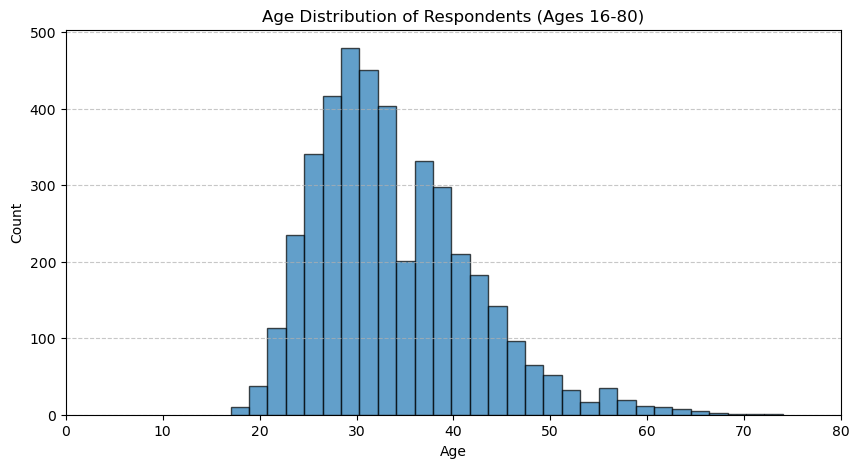

In [32]:
query = """
SELECT CAST(AnswerText AS INTEGER) AS age
FROM Answer
WHERE QuestionID = 1
AND AnswerText GLOB '[0-9]*';
"""

ages = [row[0] for row in conn.execute(query).fetchall()]
filtered_ages = [age for age in ages if 16 <= age <= 80]

plt.figure(figsize=(10, 5))
plt.hist(filtered_ages, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution of Respondents (Ages 16-80)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, 81, 10))
plt.show()

From this I can see that age distributions is more left skewed, which means most of the respondents who answered in this tech query are relatively young (from early 20 til late 40)

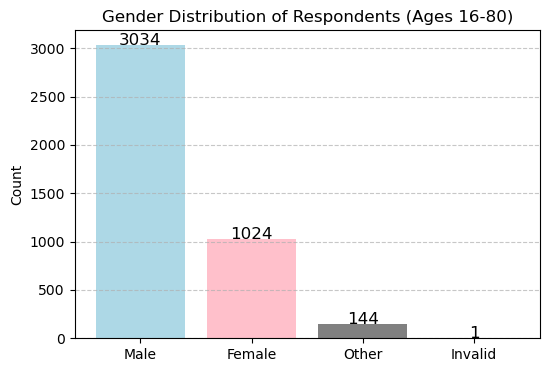

In [26]:
query = """
WITH valid_ages AS (
    SELECT UserID
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 16 AND 80
),
gender_counts AS (
    SELECT 
        CASE 
            WHEN LOWER(AnswerText) IN ('male', 'man') THEN 'Male'
            WHEN LOWER(AnswerText) IN ('female', 'woman') THEN 'Female'
            WHEN AnswerText GLOB '[0-9]*' THEN 'Invalid'
            ELSE 'Other'
        END AS gender_category
    FROM Answer
    WHERE QuestionID = 2
    AND UserID IN (SELECT UserID FROM valid_ages)
)
SELECT gender_category, COUNT(*) as count
FROM gender_counts
GROUP BY gender_category;
"""

gender_stats = conn.execute(query).fetchall()
sorted_gender_data = sorted(gender_stats, key=lambda x: x[1], reverse=True)
gender_labels_sorted, gender_counts_sorted = zip(*sorted_gender_data)

plt.figure(figsize=(6, 4))
plt.bar(gender_labels_sorted, gender_counts_sorted, color=['lightblue', 'pink', 'gray', 'red'])

for i, v in enumerate(gender_counts_sorted):
    plt.text(i, v + 2, str(v), ha='center', fontsize=12)

plt.title("Gender Distribution of Respondents (Ages 16-80)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

From this plot, I can tell that most participants in the surveys, aged 16–80, are males, with females comprising about a third of the responses. Additionally, 144 answers fall into the "Other" category, indicating that these respondents provided alternative answers (e.g., Transgender).

One answer is invalid because it is numerical.

Taking this into account, I can tell that these queries are biased toward males. However, they also showcast reall life situation in the tech industry, as around 20–35% of all employees are female (based on multiple sources found on Google).

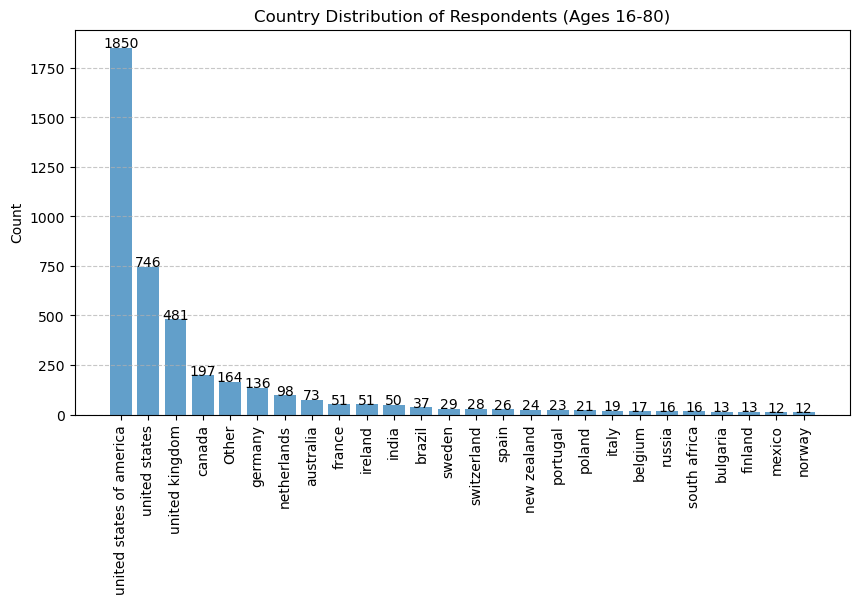

In [35]:
query = """
WITH valid_ages AS (
    SELECT UserID
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 16 AND 80
),
country_counts AS (
    SELECT AnswerText AS country, COUNT(*) AS count
    FROM Answer
    WHERE QuestionID = 3
    AND UserID IN (SELECT UserID FROM valid_ages)
    GROUP BY AnswerText
),
filtered_countries AS (
    SELECT country, count FROM country_counts WHERE count > 10
    UNION ALL
    SELECT 'Other' AS country, SUM(count) FROM country_counts WHERE count <= 10
)
SELECT country, count FROM filtered_countries ORDER BY count DESC;
"""

country_stats = conn.execute(query).fetchall()
country_labels, country_counts = zip(*country_stats)

custom_color = '#629fca'
plt.figure(figsize=(10, 5))
plt.bar(country_labels, country_counts, color=[custom_color] * len(country_labels)) 

for i, v in enumerate(country_counts):
    plt.text(i, v + 2, str(v), ha='center', fontsize=10)

plt.title("Country Distribution of Respondents (Ages 16-80)")
plt.ylabel("Count")
plt.xticks(rotation=90) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

I see that most of the respondats are from United Stets as first 2 columns both containe answer to this country. UK and Canada comes as next. 
Take in that this distribution is scewed left, I can tell that this survery is bised toward USA tech sector.  

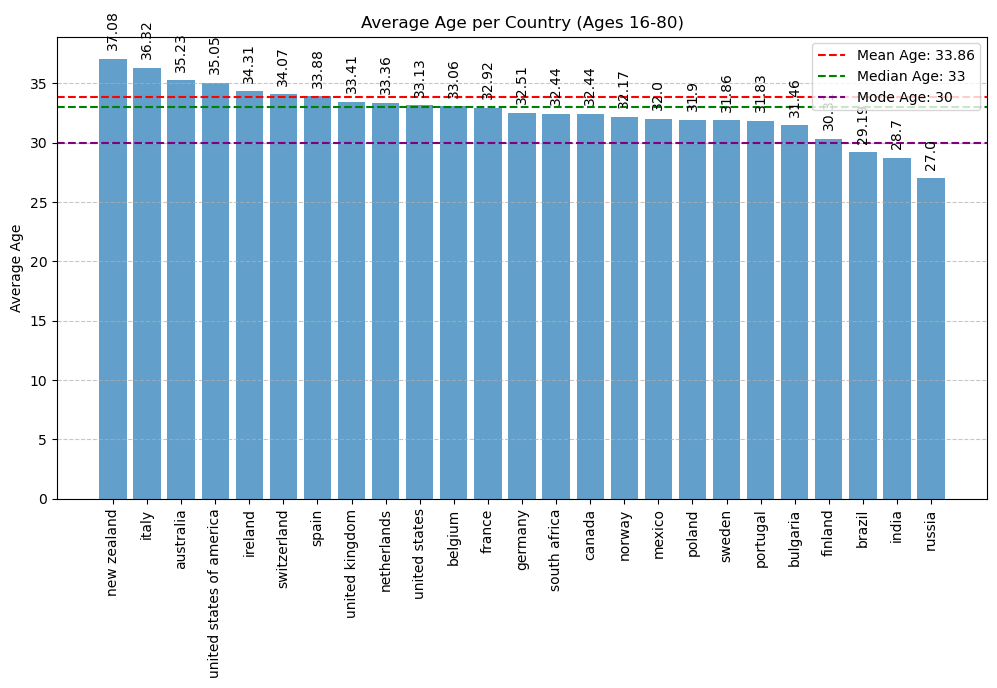

In [43]:
query = """
WITH valid_ages AS (
    SELECT UserID, CAST(AnswerText AS INTEGER) AS age
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 16 AND 80
),
country_respondents AS (
    SELECT AnswerText AS country, va.age
    FROM Answer a
    JOIN valid_ages va ON a.UserID = va.UserID
    WHERE a.QuestionID = 3
),
country_counts AS (
    SELECT country, COUNT(*) AS count, AVG(age) AS avg_age
    FROM country_respondents
    GROUP BY country
    HAVING COUNT(*) > 10
)
SELECT country, avg_age FROM country_counts ORDER BY avg_age DESC;
"""

country_age_stats = conn.execute(query).fetchall()
country_labels, avg_ages = zip(*country_age_stats)

query_stats = """
WITH valid_ages AS (
    SELECT CAST(AnswerText AS INTEGER) AS age
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 16 AND 80
)
SELECT 
    AVG(age) AS mean_age,
    (SELECT age FROM valid_ages ORDER BY age LIMIT 1 OFFSET (SELECT COUNT(*)/2 FROM valid_ages)) AS median_age,
    (SELECT age FROM valid_ages GROUP BY age ORDER BY COUNT(*) DESC LIMIT 1) AS mode_age
FROM valid_ages;
"""

mean_age, median_age, mode_age = conn.execute(query_stats).fetchone()


plt.figure(figsize=(12, 6))
plt.bar(country_labels, avg_ages, color="#629fca")

for i, v in enumerate(avg_ages):
    plt.text(i, v + 1, str(round(v, 2)), ha='center', fontsize=10, rotation=90)

plt.axhline(mean_age, color='red', linestyle='--', label=f'Mean Age: {round(mean_age, 2)}')
plt.axhline(median_age, color='green', linestyle='--', label=f'Median Age: {median_age}')
plt.axhline(mode_age, color='purple', linestyle='--', label=f'Mode Age: {mode_age}')
plt.title("Average Age per Country (Ages 16-80)")
plt.ylabel("Average Age")
plt.xticks(rotation=90) 
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Most countries have an average age between 30-35 years, with only a few significantly above or below this range.

The age distribution seems slightly skewed towards younger participants, as indicated by the mode age (30 years), which is lower than the mean and median. Countries like Spain, the United Kingdom, the Netherlands, the United States, and Belgium are very close to the mean value, suggesting that they have an age distribution typical of the dataset.

 The relatively small gap between mean, median, and mode suggests a fairly symmetrical distribution of ages.

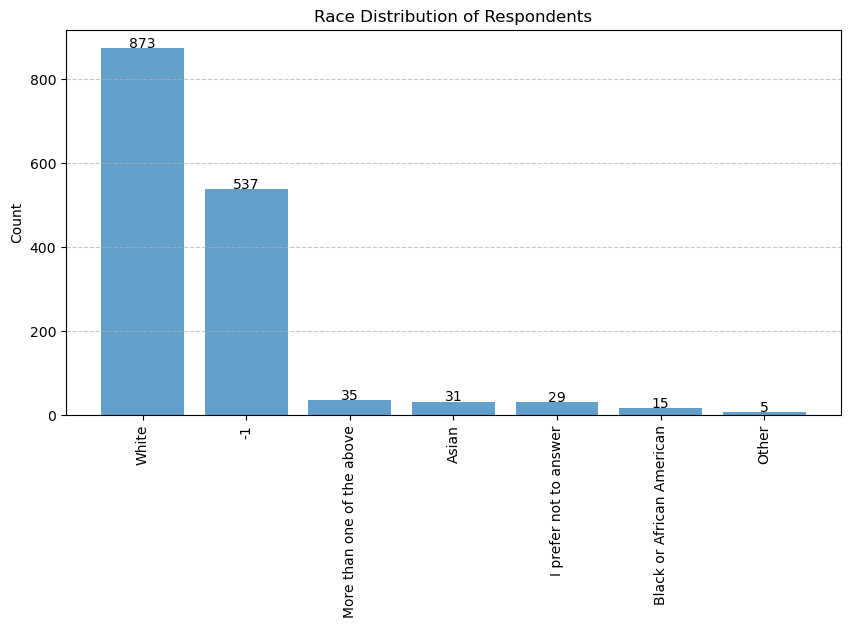

In [101]:
query = """
WITH race_counts AS (
    SELECT AnswerText AS race, COUNT(*) AS count
    FROM Answer
    WHERE QuestionID = 76
    GROUP BY AnswerText
),
filtered_races AS (
    SELECT race, count FROM race_counts WHERE count > 10
    UNION ALL
    SELECT 'Other' AS race, COALESCE(SUM(count), 0) FROM race_counts WHERE count <= 10
)
SELECT race, count FROM filtered_races ORDER BY count DESC;
"""

race_stats = conn.execute(query).fetchall()
race_labels, race_counts = zip(*[(row[0], row[1] if row[1] is not None else 0) for row in race_stats])

custom_color = "#629fca"
plt.figure(figsize=(10, 5))
plt.bar(race_labels, race_counts, color=[custom_color] * len(race_labels))

for i, v in enumerate(race_counts):
    plt.text(i, v + 2, str(v), ha='center', fontsize=10)

plt.title("Race Distribution of Respondents")
plt.ylabel("Count")
plt.xticks(rotation=90) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Do a resume. 

Looking into questions that give insight about mental health and its conditions in the tech industry.

In [102]:
query_mental_health_questions = """
SELECT QuestionID, QuestionText 
FROM Question
WHERE LOWER(QuestionText) LIKE '%mental%'
OR LOWER(QuestionText) LIKE '%disorder%' 
OR LOWER(QuestionText) LIKE '%illness%'
OR LOWER(QuestionText) LIKE '%depression%' 
OR LOWER(QuestionText) LIKE '%anxiety%'
OR LOWER(QuestionText) LIKE '%diagnosed%';
"""

mental_health_questions = conn.execute(query_mental_health_questions).fetchall()
mental_health_questions

[(6, 'Do you have a family history of mental illness?'),
 (7,
  'Have you ever sought treatment for a mental health disorder from a mental health professional?'),
 (10,
  'Does your employer provide mental health benefits as part of healthcare coverage?'),
 (11,
  'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?'),
 (12,
  'Would you bring up a mental health issue with a potential employer in an interview?'),
 (14,
  'Do you know the options for mental health care available under your employer-provided health coverage?'),
 (15,
  'Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?'),
 (16,
  'Does your employer offer resources to learn more about mental health disorders and options for seeking help?'),
 (17,
  'If a mental health issue prompted you to request a medical leave from work, how easy or difficult wo

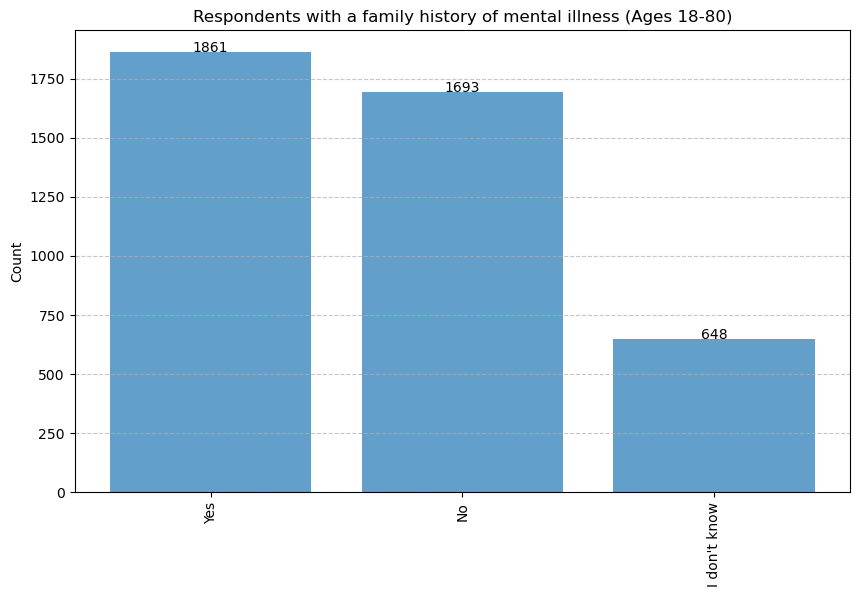

In [103]:
query = """
WITH valid_ages AS (
    SELECT UserID
    FROM Answer
    WHERE QuestionID = 1
    AND AnswerText GLOB '[0-9]*'
    AND CAST(AnswerText AS INTEGER) BETWEEN 18 AND 80
),
question_responses AS (
    SELECT AnswerText
    FROM Answer
    WHERE QuestionID = 6
    AND UserID IN (SELECT UserID FROM valid_ages)
)
SELECT AnswerText, COUNT(*) AS count
FROM question_responses
GROUP BY AnswerText
ORDER BY count DESC;
"""

responses = conn.execute(query).fetchall()
answer_texts, counts = zip(*responses)

plt.figure(figsize=(10, 6))
plt.bar(answer_texts, counts, color="#629fca")

for i, v in enumerate(counts):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=10, rotation=0) 

plt.title("Respondents with a family history of mental illness (Ages 18-80)")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

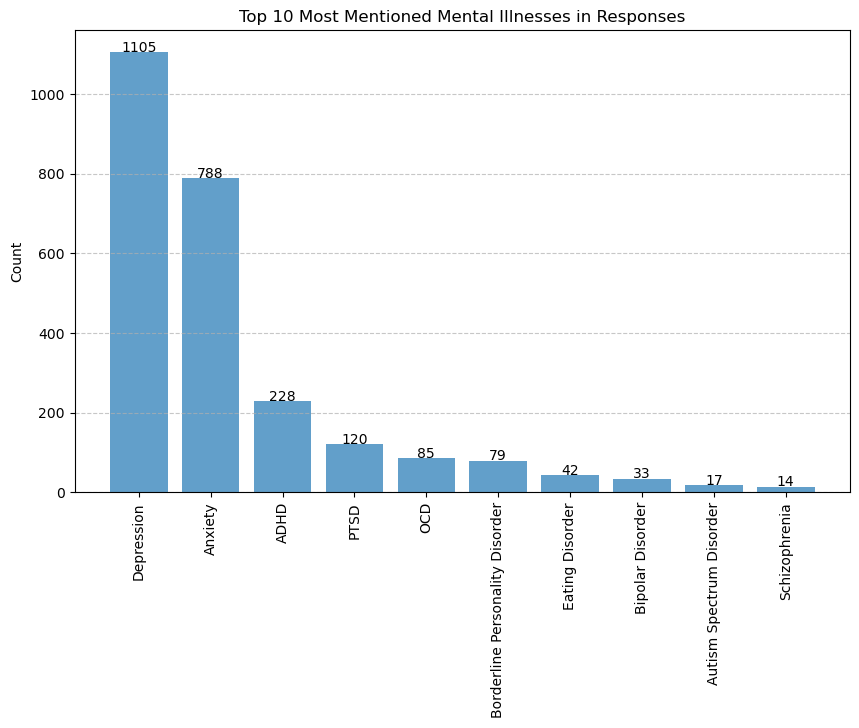

In [115]:
query_top_mental_illnesses = """
WITH extracted_illnesses AS (
    SELECT LOWER(AnswerText) AS answer
    FROM Answer
    WHERE AnswerText IS NOT NULL
),
illness_counts AS (
    SELECT 
        CASE 
            WHEN answer LIKE '%depression%' OR answer LIKE '%depresion%' THEN 'Depression'
            WHEN answer LIKE '%anxiety%' THEN 'Anxiety'
            WHEN answer LIKE '%bipolar%' THEN 'Bipolar Disorder'
            WHEN answer LIKE '%schizophrenia%' THEN 'Schizophrenia'
            WHEN answer LIKE '%ocd%' OR answer LIKE '%obsessive-compulsive%' THEN 'OCD'
            WHEN answer LIKE '%ptsd%' OR answer LIKE '%post-traumatic%' THEN 'PTSD'
            WHEN answer LIKE '%adhd%' OR answer LIKE '%attention deficit%' THEN 'ADHD'
            WHEN answer LIKE '%autism%' OR answer LIKE '%autistic%' THEN 'Autism Spectrum Disorder'
            WHEN answer LIKE '%borderline%' THEN 'Borderline Personality Disorder'
            WHEN answer LIKE '%eating disorder%' OR answer LIKE '%bulimia%' OR answer LIKE '%anorexia%' THEN 'Eating Disorder'
            ELSE NULL
        END AS mental_illness
    FROM extracted_illnesses
)
SELECT mental_illness, COUNT(*) AS count
FROM illness_counts
WHERE mental_illness IS NOT NULL
GROUP BY mental_illness
ORDER BY count DESC
LIMIT 10;
"""

top_mental_illnesses = conn.execute(query_top_mental_illnesses).fetchall()
mental_illness_labels, illness_counts = zip(*top_mental_illnesses)

plt.figure(figsize=(10, 6))
plt.bar(mental_illness_labels, illness_counts, color="#629fca")

for i, v in enumerate(illness_counts):
    plt.text(i, v + 2, str(v), ha='center', fontsize=10, rotation=0)

plt.title("Top 10 Most Mentioned Mental Illnesses in Responses")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [114]:
query_question_ids = """
WITH extracted_illnesses AS (
    SELECT QuestionID, LOWER(AnswerText) AS answer
    FROM Answer
    WHERE AnswerText IS NOT NULL
),
illness_counts AS (
    SELECT 
        QuestionID,
        CASE 
            WHEN answer LIKE '%depression%' OR answer LIKE '%depresion%' THEN 'Depression'
            WHEN answer LIKE '%anxiety%' THEN 'Anxiety'
            WHEN answer LIKE '%bipolar%' THEN 'Bipolar Disorder'
            WHEN answer LIKE '%schizophrenia%' THEN 'Schizophrenia'
            WHEN answer LIKE '%ocd%' OR answer LIKE '%obsessive-compulsive%' THEN 'OCD'
            WHEN answer LIKE '%ptsd%' OR answer LIKE '%post-traumatic%' THEN 'PTSD'
            WHEN answer LIKE '%adhd%' OR answer LIKE '%attention deficit%' THEN 'ADHD'
            WHEN answer LIKE '%autism%' OR answer LIKE '%autistic%' THEN 'Autism Spectrum Disorder'
            WHEN answer LIKE '%borderline%' THEN 'Borderline Personality Disorder'
            WHEN answer LIKE '%eating disorder%' OR answer LIKE '%bulimia%' OR answer LIKE '%anorexia%' THEN 'Eating Disorder'
            ELSE NULL
        END AS mental_illness
    FROM extracted_illnesses
)
SELECT QuestionID, mental_illness, COUNT(*) AS count
FROM illness_counts
WHERE mental_illness IS NOT NULL
GROUP BY QuestionID, mental_illness
ORDER BY count DESC;
"""

question_ids_mental_illnesses = conn.execute(query_question_ids).fetchall()
question_ids_mental_illnesses

[(102, 'Depression', 414),
 (102, 'Anxiety', 345),
 (103, 'Depression', 219),
 (103, 'Anxiety', 193),
 (102, 'ADHD', 122),
 (50, 'Depression', 104),
 (48, 'Depression', 87),
 (102, 'PTSD', 70),
 (46, 'Depression', 59),
 (103, 'ADHD', 58),
 (60, 'Depression', 56),
 (48, 'Anxiety', 54),
 (46, 'Anxiety', 52),
 (50, 'Anxiety', 49),
 (62, 'Depression', 47),
 (102, 'OCD', 45),
 (103, 'Borderline Personality Disorder', 42),
 (58, 'Depression', 40),
 (102, 'Borderline Personality Disorder', 35),
 (69, 'Depression', 32),
 (103, 'OCD', 30),
 (102, 'Eating Disorder', 28),
 (103, 'PTSD', 26),
 (60, 'Anxiety', 25),
 (58, 'Anxiety', 19),
 (90, 'Depression', 18),
 (69, 'Anxiety', 16),
 (73, 'Depression', 16),
 (62, 'Anxiety', 15),
 (73, 'Anxiety', 13),
 (74, 'Depression', 13),
 (46, 'ADHD', 11),
 (103, 'Eating Disorder', 10),
 (48, 'ADHD', 9),
 (58, 'ADHD', 8),
 (103, 'Schizophrenia', 8),
 (69, 'ADHD', 6),
 (90, 'Bipolar Disorder', 6),
 (102, 'Autism Spectrum Disorder', 6),
 (102, 'Schizophrenia', 6)